In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

%matplotlib inline

class Object(object): pass

# 3.1 Sampling from a grid-approximate posterior

#### 3.2

In [2]:
p_grid = np.linspace(0, 1, int(1e3))
prior = np.ones(1000)
likelihood = stats.binom.pmf(n=9, k=6, p=p_grid)
posterior = likelihood * prior 
posterior /= posterior.sum()

Text(0.5, 1.0, 'Posterior')

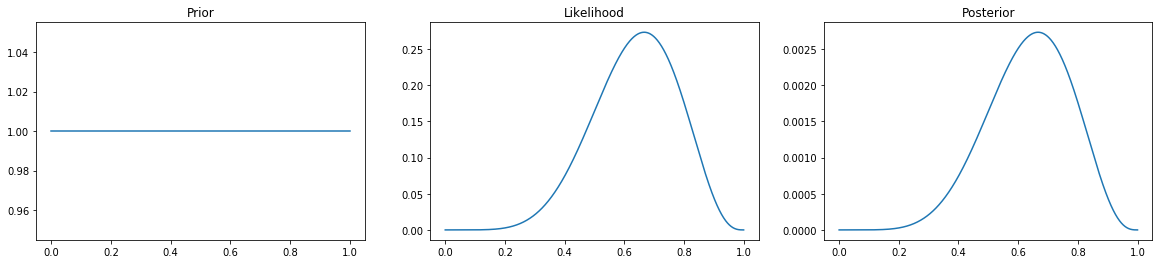

In [3]:
_32 = Object()
_32.fig, _32.ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 4))
_32.ax[0].plot(p_grid, prior)
_32.ax[0].set_title("Prior")
_32.ax[1].plot(p_grid, likelihood)
_32.ax[1].set_title("Likelihood")
_32.ax[2].plot(p_grid, posterior)
_32.ax[2].set_title("Posterior")

#### 3.3

In [4]:
samples = np.random.choice(p_grid, size=int(1e3), p=posterior, replace=True)

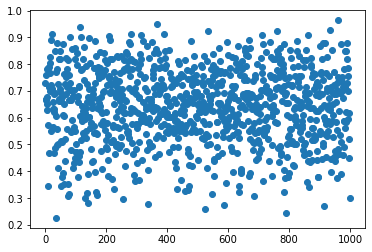

In [5]:
plt.plot(samples, marker="o", linestyle="none")

In [6]:
def dens(x, samples, smoothing_h=None):
    phi = lambda x: np.exp(-0.5 * x**2) / np.sqrt(2 * np.pi)
    # Rule of thumb smoothing, see https://en.wikipedia.org/wiki/Kernel_density_estimation
    h = smoothing_h if smoothing_h is not None \
        else np.std(samples) * (4 / 3 / samples.shape[0])**(1/5)
    result = []
    for x_i in x:
        result.append(np.mean(phi((x_i - samples) / h)) / h)
    return np.array(result)

In [7]:
samples = np.random.choice(p_grid, size=int(1e5), p=posterior, replace=True)
density = dens(p_grid, samples)

Text(0.5, 1.0, 'Posterior')

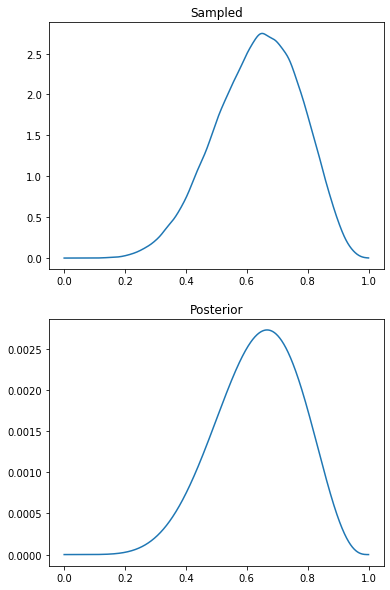

In [8]:
_33 = Object()
_33.fig, _33.ax = plt.subplots(nrows=2, ncols=1, figsize=(6, 10))
_33.ax[0].plot(p_grid, density)
_33.ax[0].set_title("Sampled")
_33.ax[1].plot(p_grid, posterior)
_33.ax[1].set_title("Posterior")

# 3.2. Sampling to summarize

What is the posterior P that water < 0.5 of the surface?

#### 3.6

In [9]:
# add up probabilities where p < 0.5
posterior[p_grid < 0.5].sum()

0.17187458902022873

#### 3.7

In [10]:
# E.g True, False, False, .... , False
samples_with_p_under_50 = samples < 0.5
number_of_sample_with_p_under_50 = samples_with_p_under_50.sum()

# Probability: # of samples with P < 0.5 / total # of samples
number_of_sample_with_p_under_50 / samples.shape[0]

0.17251

#### 3.8

In [11]:
((samples > 0.5) & (samples < 0.75)).sum() / samples.shape[0]

0.60517

The posterior intervals report two paramater values that contain between them a specified amount of posterior probability, a probability mass.

For example, you want to know the boundaries of the lower 80% posterior probability. The interval starts at p = 0. To find out where it stops, use quantile().

In [12]:
def quantile(arr, perc_list):
    def single_quantile(arr, perc):
        k = (arr.shape[0] - 1) * perc
        f = np.floor(k)
        c = np.ceil(k)
        result = None
        if f == c:
            result = arr[int(k)]
        else:
            d0 = arr[int(f)] * (c - k)
            d1 = arr[int(c)] * (k - f)
            result = d0 + d1
        return result
    
    arr = np.sort(arr)
    
    if isinstance(perc_list, list):
        perc_list = np.array(perc_list)
        
    if isinstance(perc_list, np.ndarray):
        result = np.zeros_like(perc_list)
        for i, p in enumerate(perc_list):
            result[i] = single_quantile(arr, p)
    else:
        result = single_quantile(arr, perc_list)
    return result

#### 3.9

In [13]:
quantile(samples, 0.8)

0.7597597597597597

#### 3.10

In [14]:
quantile(samples, [0.1, 0.9])

array([0.44844845, 0.81181181])

#### 3.11

In [15]:
c32 = Object()
c32.p_grid = np.linspace(0, 1, 1000)
c32.prior = np.ones(c32.p_grid.shape[0])
c32.likelihood = stats.binom.pmf(n=3, k=3, p=c32.p_grid)
c32.posterior = c32.prior * c32.likelihood
c32.posterior /= c32.posterior.sum()
c32.samples = np.random.choice(
    c32.p_grid, 
    size=int(1e5), 
    replace=True, 
    p=c32.posterior)

In [16]:
c32.ret = quantile(c32.samples, [0.25, 0.75])
print(c32.ret)

[0.70770771 0.93093093]


In [17]:
import pymc3

c32.hpdi = pymc3.stats.hpd(c32.samples, 0.5)
c32.hpdi

array([0.84184184, 1.        ])

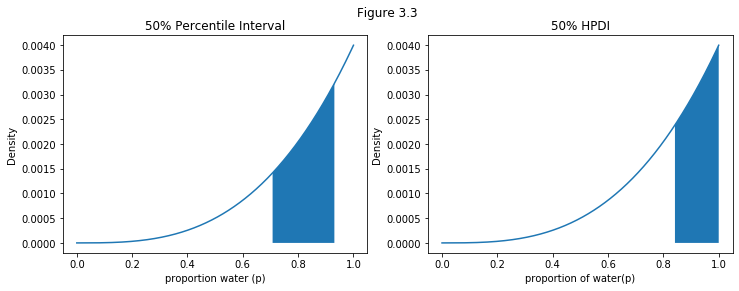

In [18]:
_311 = Object()
_311.indices = np.where(
      (c32.p_grid >= c32.ret[0]) 
    & (c32.p_grid <= c32.ret[1]))
_311.x = c32.p_grid[_311.indices]
_311.f = c32.posterior[_311.indices]

_311.fig, _311.ax = plt.subplots(figsize=(12, 4), ncols=2, nrows=1)
_311.fig.suptitle("Figure 3.3")
_311.ax[0].plot(c32.p_grid, c32.posterior)
_311.ax[0].set_title("50% Percentile Interval")
_311.ax[0].set_xlabel("proportion water (p)")
_311.ax[0].set_ylabel("Density")
_311.ax[0].fill_between(_311.x, _311.f)

_311.ax[1].plot(c32.p_grid, c32.posterior)
_311.ax[1].set_title("50% HPDI")
_311.ax[1].set_xlabel("proportion of water(p)")
_311.ax[1].set_ylabel("Density")

_311.hpd_indices = np.where(
      (c32.p_grid >= c32.hpdi[0])
    & (c32.p_grid <= c32.hpdi[1]))
_311.ax[1].fill_between(
    c32.p_grid[_311.hpd_indices], 
    c32.posterior[_311.hpd_indices])

50% PI:   [0.54054054 0.73973974]
50% HPDI: [0.55955956 0.75575576]


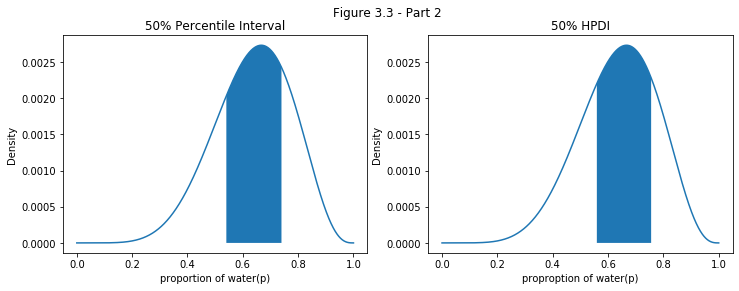

In [19]:
_ex = Object()
_ex.likelihood = stats.binom.pmf(n=9, k=6, p=c32.p_grid)
_ex.posterior = c32.prior * _ex.likelihood
_ex.posterior /= _ex.posterior.sum()
_ex.samples = np.random.choice(
    c32.p_grid,
    size=10000,
    replace=True,
    p=_ex.posterior
)
_ex.pi = quantile(_ex.samples, [0.25, 0.75])
_ex.hpdi = pymc3.stats.hpd(_ex.samples, 0.5)

_ex.fig, _ex.ax = plt.subplots(figsize=(12, 4), ncols=2, nrows=1)
_ex.fig.suptitle("Figure 3.3 - Part 2")
_ex.ax[0].set_title("50% Percentile Interval")
_ex.ax[0].set_xlabel("proportion of water(p)")
_ex.ax[0].set_ylabel("Density")
_ex.ax[0].plot(c32.p_grid, _ex.posterior)
_ex.pi_indices = np.where(
      (c32.p_grid >= _ex.pi[0])
    & (c32.p_grid <= _ex.pi[1]))
_ex.pi_x = c32.p_grid[_ex.pi_indices]
_ex.pi_f = _ex.posterior[_ex.pi_indices]
_ex.ax[0].fill_between(_ex.pi_x, _ex.pi_f)

_ex.ax[1].set_title("50% HPDI")
_ex.ax[1].set_xlabel("proproption of water(p)")
_ex.ax[1].set_ylabel("Density")
_ex.ax[1].plot(c32.p_grid, _ex.posterior)
_ex.hpd_indices = np.where(
      (c32.p_grid >= _ex.hpdi[0])
    & (c32.p_grid <= _ex.hpdi[1]))
_ex.hpd_x = c32.p_grid[_ex.hpd_indices]
_ex.hpd_f = _ex.posterior[_ex.hpd_indices]
_ex.ax[1].fill_between(_ex.hpd_x, _ex.hpd_f)

print("50% PI:  ", _ex.pi)
print("50% HPDI:", _ex.hpdi)

## 3.3 Sampling to simulate predictions

#### 3.20

In [20]:
stats.binom.pmf(k=np.arange(3), n=2, p=0.7)

array([0.09, 0.42, 0.49])

#### 3.22

In [21]:
stats.binom.rvs(n=2, p=0.7, size=10)

array([2, 1, 2, 2, 1, 1, 2, 2, 1, 2])

#### 3.23

In [22]:
_323 = Object()
_323.dummy = stats.binom.rvs(size=int(1e5), n=2, p=0.7)
_323.uniques = np.unique(_323.dummy, return_counts=True)
print(_323.uniques[0])
print(_323.uniques[1] / int(1e5))

[0 1 2]
[0.08879 0.42305 0.48816]


#### 3.24

Text(0, 0.5, 'Frequency')

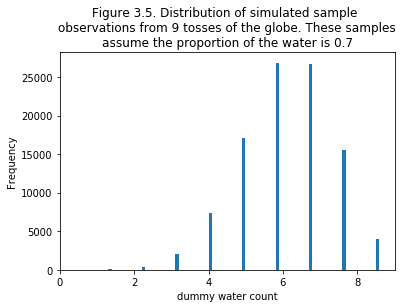

In [23]:
_342 = Object()
_342.dummy_w = stats.binom.rvs(size=int(1e5), n=9, p=0.7)

plt.hist(_342.dummy_w, rwidth=0.1)

plt.title("""Figure 3.5. Distribution of simulated sample 
observations from 9 tosses of the globe. These samples
assume the proportion of the water is 0.7""")
plt.xlabel('dummy water count')
plt.ylabel('Frequency')

#### 3.26

Text(0, 0.5, 'Posterior predictive distribution (frequency)')

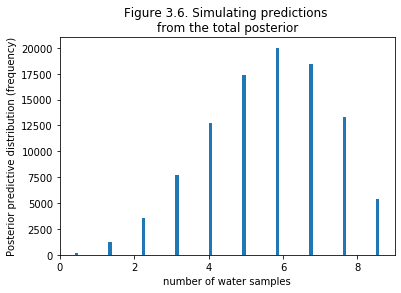

In [24]:
_326 = Object()
_326.p_grid = np.linspace(0, 1, int(1e3))
_326.prior = np.ones_like(_326.p_grid)
_326.likelihood = stats.binom.pmf(n=9, k=6, p=_326.p_grid)
_326.posterior = _326.prior * _326.likelihood
_326.posterior /= _326.posterior.sum()
_326.samples = np.random.choice(
    _326.p_grid, 
    size=int(1e5), 
    replace=True,
    p=_326.posterior)

_326.w = stats.binom.rvs(n=9, p=_326.samples)

plt.hist(_326.w, rwidth=0.1)

plt.title("""Figure 3.6. Simulating predictions 
from the total posterior""")
plt.xlabel("number of water samples")
plt.ylabel("Posterior predictive distribution (frequency)")

# 3.5 Practice

### Easy

In [94]:
_e = Object()
_e.p_grid = np.linspace(0, 1, 1000)
_e.prior = np.repeat(1, 1000)
_e.likelihood = stats.binom.pmf(k=6, n=9, p=_e.p_grid)
_e.posterior = _e.likelihood * _e.prior
_e.posterior /= _e.posterior.sum()
_e.random_state = 101
np.random.seed(_e.random_state)
_e.samples = np.random.choice(_e.p_grid, size=100000, p=_e.posterior)

**3E1**. How much posterior probability lies below p = 0.2?

In [95]:
_e.posterior[:int(len(_e.posterior) * 0.2)].sum()

0.0008560951294218479

In [96]:
(_e.samples < 0.2).mean()

0.00079

**3E2**. How much posterior probability likes above p = 0.8?

In [97]:
_e.posterior[int(len(_e.posterior) * 0.8) : ].sum()

0.12034491402214356

In [98]:
(_e.samples > 0.8).mean()

0.12036

**3E3**. How much posterior probability lies between p = 0.2 and p = 0.8?

In [106]:
_e.posterior[
      int(len(_e.posterior) * 0.2) 
    : int(len(_e.posterior) * 0.8) 
].sum()

0.8787989908484345

In [107]:
quantile(_e.samples, [0.000856, 0.8787])

array([0.2022022, 0.7997998])

In [108]:
((_e.samples > 0.2) & (_e.samples < 0.8)).mean()

0.87885

**3E4**. 20% of the posterior probability lies below which value of p?

In [109]:
quantile(_e.samples, [0.2])

array([0.51651652])

p < 0.5165

In [110]:
np.percentile(_e.samples, 20)

0.5165165165165165

**3E5**. 20% of the posterior probability lies above which value of p?

In [111]:
quantile(_e.samples, [0.8])

array([0.76076076])

In [112]:
np.percentile(_e.samples, 80)

0.7607607607607607

P > 0.7587

**3E6**. Which values of p contain the narrowest interval equal to 66% of the posterior probability?

In [115]:
_e.hpd = pymc3.stats.hpd(_e.samples, 0.66)
_e.hpd

array([0.51651652, 0.78878879])

In [114]:
((_e.samples > 0.51651652) & (_e.samples < 0.78878879)).mean()

0.65842

In [116]:
_e.hpd[1] - _e.hpd[0]

0.27227227227227224

**3E7**. Which values of p contain 66% of the posterior probability, assuming equal posterior probability both below and above the interval?

In [126]:
_e.int = [(1-0.66) / 2, (1-0.66) / 2 + 0.66]
print(_e.int)
_e.eq_int = quantile(_e.samples, _e.int)
_e.eq_int

[0.16999999999999998, 0.8300000000000001]


array([0.4994995 , 0.77477477])

In [125]:
quantile(_e.samples, [1/6, 5/6])

array([0.4974975 , 0.77677678])

In [127]:
_e.eq_int[1]- _e.eq_int[0]

0.27527527527527523

This interval is slightly wider than the Highest Posterior Density Interval in 3E6.

In [128]:
(_e.eq_int[1]- _e.eq_int[0]) - (_e.hpd[1] - _e.hpd[0])

0.003003003003002991